In [10]:
import collections.abc
import functools
import inspect
import math

import numpy
import pandas
import scipy.ndimage
import scipy.stats
import skimage.color
import skimage.measure
import skimage.morphology
import skimage.segmentation
import skimage.measure

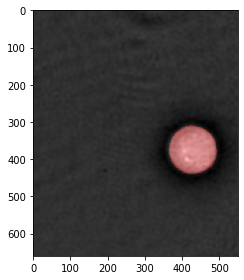

In [2]:
image = skimage.data.cell()

equalized = skimage.filters.gaussian(image, 8)
equalized = skimage.exposure.equalize_adapthist(equalized)

masks = equalized > skimage.filters.threshold_li(equalized)
masks = skimage.morphology.remove_small_objects(masks, 128)
masks = skimage.measure.label(masks)
masks = skimage.segmentation.clear_border(masks)
masks = skimage.measure.label(masks)

skimage.io.imshow(skimage.color.label2rgb(masks, image, bg_label=0))

In [61]:
import collections.abc
import functools
import inspect
import math

import numpy
import scipy.ndimage
import scipy.stats
import skimage.color
import skimage.measure
import skimage.morphology
import skimage.segmentation
import skimage.measure


def cache(wrapped):
    @functools.wraps(wrapped)
    def function(generator: "Generator"):
        name = wrapped.__name__

        if not (name in generator.cache):
            generator.cache[name] = wrapped(generator)

        return generator.cache[name]

    return function


class Generator(collections.abc.Iterator):
    def __init__(self, masks, image):
        self.cache = {}

        if masks.shape[-1] == 4:
            masks = masks[:, :, 0]

        if image.shape[-1] == 4:
            image = image[:, :, :-1]

            image = skimage.color.rgb2gray(image)

        self.image = skimage.img_as_float32(image)

        self.masks = masks

        self.index = 0

        self.multichannel = masks.shape < image.shape

        self.objects = scipy.ndimage.find_objects(masks)

        self.object_index = 1  # skip background (`0`)

        self.object = self.objects[self.object_index - 1]

        self.volumetric = False

        self._cropped = None

        self._spatial_axes = tuple(range(masks.ndim))

    def __iter__(self):
        return self

    def __next__(self):
        try:
            self.object = self.objects[self.index]
        except IndexError:
            raise StopIteration

        features = [getattr(self, member) for member in self._members]

        self.index += 1

        return features

    @property
    def area(self):
        return numpy.sum(self.masks)

    @property
    def bounding_box(self):
        return self.regionprops.bbox

    @property
    def central_moments(self):
        v = numpy.zeros((4, 4, 4))

        v[0] = skimage.measure.moments_central(skimage.img_as_ubyte(self.masked), order=3)

        return v

    @property
    def centroid(self):
        return self.coordinates.mean(axis=0)

    @property
    def columns(self):
        return [member.replace("_feature_", "") for member in self._members]

    @property
    def convex_hull(self):
        return skimage.morphology.convex_hull_image(self.mask)

    @property
    def coordinates(self):
        indices = numpy.nonzero(self.image)

        stack = []

        for index in range(self.masks.ndim):
            stack += [indices[index] + self.object[index].start]

        return numpy.vstack(stack).T

    @property
    def crop(self):
        return self.image[self.object]

    @property
    def edge(self):
        boundary = skimage.segmentation.find_boundaries(self.mask, mode="outer")

        return self.crop * boundary

    @property
    def inertia_tensor(self):
        return skimage.measure.inertia_tensor(self.image, self.central_moments)

    @property
    def inertia_tensor_eigenvalues(self):
        return skimage.measure.inertia_tensor_eigvals(self.masks, T=self.inertia_tensor)

    @property
    def local_centroid(self):
        spatial_moments = self.spatial_moments

        return tuple(spatial_moments[tuple(numpy.eye(self.masks.ndim, dtype=int))] / spatial_moments[(0,) * self.masks.ndim])

    @property
    def mask(self):
        return numpy.squeeze(self.masks[self.object]) > 0

    @property
    def masked(self):
        return self.image[self.object] * self.mask

    @property
    def perimeter(self):
        return self.regionprops.perimeter

    @property
    def regionprops(self):
        return skimage.measure.regionprops(self.masks, self.image)[self.index]

    @property
    def spatial_moments(self):
        v = numpy.zeros((4, 4, 4))

        v[0] = skimage.measure.moments(skimage.img_as_ubyte(self.masked), order=3)

        return v

    # General-purpose features

    # Color

    # Color: Image

    @property
    def _feature_color_image_integrated_intensity(self):
        return numpy.sum(self.image)

    @property
    def _feature_color_image_maximum_intensity(self):
        return numpy.max(self.image)

    @property
    def _feature_color_image_mean_intensity(self):
        return numpy.mean(self.image)

    @property
    def _feature_color_image_median_absolute_deviation_intensity(self):
        return scipy.stats.median_abs_deviation(self.image.reshape(-1, ))

    @property
    def _feature_color_image_median_intensity(self):
        return numpy.median(self.image)

    @property
    def _feature_color_image_minimum_intensity(self):
        return numpy.min(self.image)

    @property
    def _feature_color_image_quantile_1_intensity(self):
        return numpy.quantile(self.image, 0.25)

    @property
    def _feature_color_image_quantile_3_intensity(self):
        return numpy.quantile(self.image, 0.75)

    @property
    def _feature_color_image_standard_deviation_intensity(self):
        return numpy.std(self.image)

    # Color: Object

    @property
    def _feature_color_object_edge_integrated_intensity(self):
        return numpy.sum(self.edge)

    @property
    def _feature_color_object_edge_maximum_intensity(self):
        return numpy.max(self.edge)

    @property
    def _feature_color_object_edge_mean_intensity(self):
        return numpy.mean(self.edge)

    @property
    def _feature_color_object_edge_median_intensity(self):
        return numpy.median(self.edge)

    @property
    def _feature_color_object_edge_minimum_intensity(self):
        return numpy.min(self.edge)

    @property
    def _feature_color_object_edge_quantile_1_intensity(self):
        return numpy.quantile(self.edge, 0.25)

    @property
    def _feature_color_object_edge_quantile_3_intensity(self):
        return numpy.quantile(self.edge, 0.75)

    @property
    def _feature_color_object_edge_standard_deviation_intensity(self):
        return numpy.std(self.edge)

    @property
    def _feature_color_object_center_mass_intensity_x(self):
        return numpy.nan

    @property
    def _feature_color_object_center_mass_intensity_y(self):
        return numpy.nan

    @property
    def _feature_color_object_integrated_intensity(self):
        return numpy.sum(self.masked)

    @property
    def _feature_color_object_mass_displacement(self):
        return numpy.nan

    @property
    def _feature_color_object_maximum_intensity(self):
        return numpy.max(self.masked)

    @property
    def _feature_color_object_maximum_intensity_x(self):
        xs, _ = numpy.where(self.image == self._feature_color_object_maximum_intensity)

        # If there are multiple matches, first match is returned.
        return xs[0]

    @property
    def _feature_color_object_maximum_intensity_y(self):
        _, ys = numpy.where(self.image == self._feature_color_object_maximum_intensity)

        # If there are multiple matches, first match is returned.
        return ys[0]

    @property
    def _feature_color_object_mean_intensity(self):
        return numpy.mean(self.masked)

    @property
    def _feature_color_object_median_absolute_deviation_intensity(self):
        return scipy.stats.median_abs_deviation(self.masked.reshape(-1, ))

    @property
    def _feature_color_object_median_intensity(self):
        return numpy.median(self.masked)

    @property
    def _feature_color_object_minimum_intensity(self):
        return numpy.min(self.masked)

    @property
    def _feature_color_object_quantile_1_intensity(self):
        return numpy.quantile(self.masked, 0.25)

    @property
    def _feature_color_object_quantile_3_intensity(self):
        return numpy.quantile(self.masked, 0.75)

    @property
    def _feature_color_object_standard_deviation_intensity(self):
        return numpy.std(self.masked)

    # Location

    # Location: Object neighborhood

    @property
    def _feature_location_object_neighborhood_angle(self):
        return numpy.nan

    @property
    def _feature_location_object_neighborhood_closest_0_distance(self):
        return numpy.nan

    @property
    def _feature_location_object_neighborhood_closest_0_object_index(self):
        return numpy.nan

    @property
    def _feature_location_object_neighborhood_closest_1_distance(self):
        return numpy.nan

    @property
    def _feature_location_object_neighborhood_closest_1_object_index(self):
        return numpy.nan

    @property
    def _feature_location_object_neighborhood_closest_2_distance(self):
        return numpy.nan

    @property
    def _feature_location_object_neighborhood_closest_2_object_index(self):
        return numpy.nan

    @property
    def _feature_location_object_neighborhood_neighbors(self):
        return numpy.nan

    @property
    def _feature_location_object_neighborhood_touching(self):
        return numpy.nan

    # Metadata

    # Metadata: Image

    @property
    def _feature_metadata_image_checksum(self):
        return numpy.nan

    @property
    def _feature_metadata_image_filename(self):
        return numpy.nan

    # Metadata: Napari Layer

    @property
    def _feature_metadata_layer_name(self):
        return numpy.nan

    @property
    def _feature_metadata_layer_type(self):
        return numpy.nan

    # Metadata: Object

    @property
    def _feature_metadata_object_index(self):
        return self.object_index

    # Shape

    # Shape: Image

    @property
    def _feature_shape_image_area(self):
        if self.multichannel:
            return numpy.product(numpy.product(self.image.shape[:-1]))
        else:
            return numpy.product(numpy.product(self.image.shape))

    # Shape: Image skeleton

    @property
    def _feature_shape_image_skeleton_branches(self):
        return numpy.nan

    @property
    def _feature_shape_image_skeleton_endpoints(self):
        return numpy.nan

    @property
    def _feature_shape_image_skeleton_length(self):
        return numpy.nan

    @property
    def _feature_shape_image_skeleton_trunks(self):
        return numpy.nan

    # Shape: Object

    @property
    def _feature_shape_object_area(self):
        return self.regionprops.area

    @property
    def _feature_shape_object_bounding_box_area(self):
        return self.regionprops.bbox_area

    @property
    def _feature_shape_object_bounding_box_maximum_x(self):
        return self.bounding_box[2]

    @property
    def _feature_shape_object_bounding_box_maximum_y(self):
        return self.bounding_box[3]

    @property
    def _feature_shape_object_bounding_box_maximum_z(self):
        return numpy.nan

    @property
    def _feature_shape_object_bounding_box_minimum_x(self):
        return self.bounding_box[0]

    @property
    def _feature_shape_object_bounding_box_minimum_y(self):
        return self.bounding_box[1]

    @property
    def _feature_shape_object_bounding_box_minimum_z(self):
        return numpy.nan

    @property
    def _feature_shape_object_central_moment_0_0_0(self):
        return self.central_moments[0, 0, 0]

    @property
    def _feature_shape_object_central_moment_0_0_1(self):
        return self.central_moments[0, 0, 1]

    @property
    def _feature_shape_object_central_moment_0_0_2(self):
        return self.central_moments[0, 0, 2]

    @property
    def _feature_shape_object_central_moment_0_0_3(self):
        return self.central_moments[0, 0, 3]

    @property
    def _feature_shape_object_central_moment_0_1_0(self):
        return self.central_moments[0, 1, 0]

    @property
    def _feature_shape_object_central_moment_0_1_1(self):
        return self.central_moments[0, 1, 1]

    @property
    def _feature_shape_object_central_moment_0_1_2(self):
        return self.central_moments[0, 1, 2]

    @property
    def _feature_shape_object_central_moment_0_1_3(self):
        return self.central_moments[0, 1, 3]

    @property
    def _feature_shape_object_central_moment_0_2_0(self):
        return self.central_moments[0, 2, 0]

    @property
    def _feature_shape_object_central_moment_0_2_1(self):
        return self.central_moments[0, 2, 1]

    @property
    def _feature_shape_object_central_moment_0_2_2(self):
        return self.central_moments[0, 2, 2]

    @property
    def _feature_shape_object_central_moment_0_2_3(self):
        return self.central_moments[0, 2, 3]

    @property
    def _feature_shape_object_central_moment_0_3_0(self):
        return self.central_moments[0, 3, 0]

    @property
    def _feature_shape_object_central_moment_0_3_1(self):
        return self.central_moments[0, 3, 1]

    @property
    def _feature_shape_object_central_moment_0_3_2(self):
        return self.central_moments[0, 3, 2]

    @property
    def _feature_shape_object_central_moment_0_3_3(self):
        return self.central_moments[0, 3, 3]

    @property
    def _feature_shape_object_central_moment_1_0_0(self):
        return self.central_moments[1, 0, 0]

    @property
    def _feature_shape_object_central_moment_1_0_1(self):
        return self.central_moments[1, 0, 1]

    @property
    def _feature_shape_object_central_moment_1_0_2(self):
        return self.central_moments[1, 0, 2]

    @property
    def _feature_shape_object_central_moment_1_0_3(self):
        return self.central_moments[1, 0, 3]

    @property
    def _feature_shape_object_central_moment_1_1_0(self):
        return self.central_moments[1, 1, 0]

    @property
    def _feature_shape_object_central_moment_1_1_1(self):
        return self.central_moments[1, 1, 1]

    @property
    def _feature_shape_object_central_moment_1_1_2(self):
        return self.central_moments[1, 1, 2]

    @property
    def _feature_shape_object_central_moment_1_1_3(self):
        return self.central_moments[1, 1, 3]

    @property
    def _feature_shape_object_central_moment_1_2_0(self):
        return self.central_moments[1, 2, 0]

    @property
    def _feature_shape_object_central_moment_1_2_1(self):
        return self.central_moments[1, 2, 1]

    @property
    def _feature_shape_object_central_moment_1_2_2(self):
        return self.central_moments[1, 2, 2]

    @property
    def _feature_shape_object_central_moment_1_2_3(self):
        return self.central_moments[1, 2, 3]

    @property
    def _feature_shape_object_central_moment_1_3_0(self):
        return self.central_moments[1, 3, 0]

    @property
    def _feature_shape_object_central_moment_1_3_1(self):
        return self.central_moments[1, 3, 1]

    @property
    def _feature_shape_object_central_moment_1_3_2(self):
        return self.central_moments[1, 3, 2]

    @property
    def _feature_shape_object_central_moment_1_3_3(self):
        return self.central_moments[1, 3, 3]

    @property
    def _feature_shape_object_central_moment_2_0_0(self):
        return self.central_moments[2, 0, 0]

    @property
    def _feature_shape_object_central_moment_2_0_1(self):
        return self.central_moments[2, 0, 1]

    @property
    def _feature_shape_object_central_moment_2_0_2(self):
        return self.central_moments[2, 0, 2]

    @property
    def _feature_shape_object_central_moment_2_0_3(self):
        return self.central_moments[2, 0, 3]

    @property
    def _feature_shape_object_central_moment_2_1_0(self):
        return self.central_moments[2, 1, 0]

    @property
    def _feature_shape_object_central_moment_2_1_1(self):
        return self.central_moments[2, 1, 1]

    @property
    def _feature_shape_object_central_moment_2_1_2(self):
        return self.central_moments[2, 1, 2]

    @property
    def _feature_shape_object_central_moment_2_1_3(self):
        return self.central_moments[2, 1, 3]

    @property
    def _feature_shape_object_central_moment_2_2_0(self):
        return self.central_moments[2, 2, 0]

    @property
    def _feature_shape_object_central_moment_2_2_1(self):
        return self.central_moments[2, 2, 1]

    @property
    def _feature_shape_object_central_moment_2_2_2(self):
        return self.central_moments[2, 2, 2]

    @property
    def _feature_shape_object_central_moment_2_2_3(self):
        return self.central_moments[2, 2, 3]

    @property
    def _feature_shape_object_central_moment_2_3_0(self):
        return self.central_moments[2, 3, 0]

    @property
    def _feature_shape_object_central_moment_2_3_1(self):
        return self.central_moments[2, 3, 1]

    @property
    def _feature_shape_object_central_moment_2_3_2(self):
        return self.central_moments[2, 3, 2]

    @property
    def _feature_shape_object_central_moment_2_3_3(self):
        return self.central_moments[2, 3, 3]

    @property
    def _feature_shape_object_central_moment_3_0_0(self):
        return self.central_moments[3, 0, 0]

    @property
    def _feature_shape_object_central_moment_3_0_1(self):
        return self.central_moments[3, 0, 1]

    @property
    def _feature_shape_object_central_moment_3_0_2(self):
        return self.central_moments[3, 0, 2]

    @property
    def _feature_shape_object_central_moment_3_0_3(self):
        return self.central_moments[3, 0, 3]

    @property
    def _feature_shape_object_central_moment_3_1_0(self):
        return self.central_moments[3, 1, 0]

    @property
    def _feature_shape_object_central_moment_3_1_1(self):
        return self.central_moments[3, 1, 1]

    @property
    def _feature_shape_object_central_moment_3_1_2(self):
        return self.central_moments[3, 1, 2]

    @property
    def _feature_shape_object_central_moment_3_1_3(self):
        return self.central_moments[3, 1, 3]

    @property
    def _feature_shape_object_central_moment_3_2_0(self):
        return self.central_moments[3, 2, 0]

    @property
    def _feature_shape_object_central_moment_3_2_1(self):
        return self.central_moments[3, 2, 1]

    @property
    def _feature_shape_object_central_moment_3_2_2(self):
        return self.central_moments[3, 2, 2]

    @property
    def _feature_shape_object_central_moment_3_2_3(self):
        return self.central_moments[3, 2, 3]

    @property
    def _feature_shape_object_central_moment_3_3_0(self):
        return self.central_moments[3, 3, 0]

    @property
    def _feature_shape_object_central_moment_3_3_1(self):
        return self.central_moments[3, 3, 1]

    @property
    def _feature_shape_object_central_moment_3_3_2(self):
        return self.central_moments[3, 3, 2]

    @property
    def _feature_shape_object_central_moment_3_3_3(self):
        return self.central_moments[3, 3, 3]

    @property
    def _feature_shape_object_centroid_x(self):
        return self.centroid[0]

    @property
    def _feature_shape_object_centroid_y(self):
        return self.centroid[1]

    @property
    def _feature_shape_object_centroid_z(self):
        return numpy.nan

    @property
    def _feature_shape_object_compactness(self):
        """
        The ratio of the area of the object to the area of a circle with the same perimeter:

            $compactness=\frac{4\pi}{perimeter^{2}}$
        """
        return (4 * numpy.pi * self.area) / numpy.square(self.perimeter)

    @property
    def _feature_shape_object_eccentricity(self):
        """
        The ratio of the minor axis length to the major axis length of an object:

            $eccentricity=\frac{minor\;axis_{\;length}}{major\;axis_{\;length}}$
        """
        return numpy.nan

    @property
    def _feature_shape_object_elongation(self):
        """
        The ratio between the height and width of the object's bounding box:

            $elongation=\frac{bounding\;box_{\;width}}{bounding\;box_{\;height}}$
        """
        return (self.bounding_box[3] - self.bounding_box[1]) / (self.bounding_box[2] - self.bounding_box[0])

    @property
    def _feature_shape_object_equivalent_diameter(self):
        return (2 * self.masks.ndim * self.area / math.pi) ** (1 / self.masks.ndim)

    @property
    def _feature_shape_object_euler_number(self):
        return skimage.measure.euler_number(self.masks, self.masks.ndim)

    @property
    def _feature_shape_object_extent(self):
        return self.area / self.masks.size

    @property
    def _feature_shape_object_form_factor(self):
        return self.regionprops.moments_hu[0]

    @property
    def _feature_shape_object_hu_moment_0(self):
        return self.regionprops.moments_hu[0]

    @property
    def _feature_shape_object_hu_moment_1(self):
        return self.regionprops.moments_hu[1]

    @property
    def _feature_shape_object_hu_moment_2(self):
        return self.regionprops.moments_hu[2]

    @property
    def _feature_shape_object_hu_moment_3(self):
        return self.regionprops.moments_hu[3]

    @property
    def _feature_shape_object_hu_moment_4(self):
        return self.regionprops.moments_hu[4]

    @property
    def _feature_shape_object_hu_moment_5(self):
        return self.regionprops.moments_hu[5]

    @property
    def _feature_shape_object_hu_moment_6(self):
        return self.regionprops.moments_hu[6]

    @property
    def _feature_shape_object_inertia_tensor_eigenvalues_x(self):
        return self.regionprops.inertia_tensor_eigvals[0]

    @property
    def _feature_shape_object_inertia_tensor_eigenvalues_y(self):
        return self.regionprops.inertia_tensor_eigvals[1]

    @property
    def _feature_shape_object_inertia_tensor_eigenvalues_z(self):
        return numpy.nan

    @property
    def _feature_shape_object_inertia_tensor_x_x(self):
        return numpy.nan

    @property
    def _feature_shape_object_inertia_tensor_x_y(self):
        return numpy.nan

    @property
    def _feature_shape_object_inertia_tensor_x_z(self):
        return numpy.nan

    @property
    def _feature_shape_object_inertia_tensor_y_x(self):
        return numpy.nan

    @property
    def _feature_shape_object_inertia_tensor_y_y(self):
        return numpy.nan

    @property
    def _feature_shape_object_inertia_tensor_y_z(self):
        return numpy.nan

    @property
    def _feature_shape_object_inertia_tensor_z_x(self):
        return numpy.nan

    @property
    def _feature_shape_object_inertia_tensor_z_y(self):
        return numpy.nan

    @property
    def _feature_shape_object_inertia_tensor_z_z(self):
        return numpy.nan

    @property
    def _feature_shape_object_major_axis_length(self):
        return self.regionprops.major_axis_length

    @property
    def _feature_shape_object_maximum_feret_diameter(self):
        return numpy.nan

    @property
    def _feature_shape_object_maximum_radius(self):
        return numpy.nan

    @property
    def _feature_shape_object_mean_radius(self):
        return numpy.nan

    @property
    def _feature_shape_object_median_radius(self):
        return numpy.nan

    @property
    def _feature_shape_object_minimum_feret_diameter(self):
        return numpy.nan

    @property
    def _feature_shape_object_minor_axis_length(self):
        return self.regionprops.minor_axis_length

    @property
    def _feature_shape_object_normalized_moment_x_y(self):
        return numpy.nan

    @property
    def _feature_shape_object_orientation(self):
        return self.regionprops.orientation

    @property
    def _feature_shape_object_perimeter(self):
        return self.perimeter

    @property
    def _feature_shape_object_solidity(self):
        return numpy.nan

    @property
    def _feature_shape_object_spatial_moment_0_0_0(self):
        return self.spatial_moments[0, 0, 0]

    @property
    def _feature_shape_object_spatial_moment_0_0_1(self):
        return self.spatial_moments[0, 0, 1]

    @property
    def _feature_shape_object_spatial_moment_0_0_2(self):
        return self.spatial_moments[0, 0, 2]

    @property
    def _feature_shape_object_spatial_moment_0_0_3(self):
        return self.spatial_moments[0, 0, 3]

    @property
    def _feature_shape_object_spatial_moment_0_1_0(self):
        return self.spatial_moments[0, 1, 0]

    @property
    def _feature_shape_object_spatial_moment_0_1_1(self):
        return self.spatial_moments[0, 1, 1]

    @property
    def _feature_shape_object_spatial_moment_0_1_2(self):
        return self.spatial_moments[0, 1, 2]

    @property
    def _feature_shape_object_spatial_moment_0_1_3(self):
        return self.spatial_moments[0, 1, 3]

    @property
    def _feature_shape_object_spatial_moment_0_2_0(self):
        return self.spatial_moments[0, 2, 0]

    @property
    def _feature_shape_object_spatial_moment_0_2_1(self):
        return self.spatial_moments[0, 2, 1]

    @property
    def _feature_shape_object_spatial_moment_0_2_2(self):
        return self.spatial_moments[0, 2, 2]

    @property
    def _feature_shape_object_spatial_moment_0_2_3(self):
        return self.spatial_moments[0, 2, 3]

    @property
    def _feature_shape_object_spatial_moment_0_3_0(self):
        return self.spatial_moments[0, 3, 0]

    @property
    def _feature_shape_object_spatial_moment_0_3_1(self):
        return self.spatial_moments[0, 3, 1]

    @property
    def _feature_shape_object_spatial_moment_0_3_2(self):
        return self.spatial_moments[0, 3, 2]

    @property
    def _feature_shape_object_spatial_moment_0_3_3(self):
        return self.spatial_moments[0, 3, 3]

    @property
    def _feature_shape_object_spatial_moment_1_0_0(self):
        return self.spatial_moments[1, 0, 0]

    @property
    def _feature_shape_object_spatial_moment_1_0_1(self):
        return self.spatial_moments[1, 0, 1]

    @property
    def _feature_shape_object_spatial_moment_1_0_2(self):
        return self.spatial_moments[1, 0, 2]

    @property
    def _feature_shape_object_spatial_moment_1_0_3(self):
        return self.spatial_moments[1, 0, 3]

    @property
    def _feature_shape_object_spatial_moment_1_1_0(self):
        return self.spatial_moments[1, 1, 0]

    @property
    def _feature_shape_object_spatial_moment_1_1_1(self):
        return self.spatial_moments[1, 1, 1]

    @property
    def _feature_shape_object_spatial_moment_1_1_2(self):
        return self.spatial_moments[1, 1, 2]

    @property
    def _feature_shape_object_spatial_moment_1_1_3(self):
        return self.spatial_moments[1, 1, 3]

    @property
    def _feature_shape_object_spatial_moment_1_2_0(self):
        return self.spatial_moments[1, 2, 0]

    @property
    def _feature_shape_object_spatial_moment_1_2_1(self):
        return self.spatial_moments[1, 2, 1]

    @property
    def _feature_shape_object_spatial_moment_1_2_2(self):
        return self.spatial_moments[1, 2, 2]

    @property
    def _feature_shape_object_spatial_moment_1_2_3(self):
        return self.spatial_moments[1, 2, 3]

    @property
    def _feature_shape_object_spatial_moment_1_3_0(self):
        return self.spatial_moments[1, 3, 0]

    @property
    def _feature_shape_object_spatial_moment_1_3_1(self):
        return self.spatial_moments[1, 3, 1]

    @property
    def _feature_shape_object_spatial_moment_1_3_2(self):
        return self.spatial_moments[1, 3, 2]

    @property
    def _feature_shape_object_spatial_moment_1_3_3(self):
        return self.spatial_moments[1, 3, 3]

    @property
    def _feature_shape_object_spatial_moment_2_0_0(self):
        return self.spatial_moments[2, 0, 0]

    @property
    def _feature_shape_object_spatial_moment_2_0_1(self):
        return self.spatial_moments[2, 0, 1]

    @property
    def _feature_shape_object_spatial_moment_2_0_2(self):
        return self.spatial_moments[2, 0, 2]

    @property
    def _feature_shape_object_spatial_moment_2_0_3(self):
        return self.spatial_moments[2, 0, 3]

    @property
    def _feature_shape_object_spatial_moment_2_1_0(self):
        return self.spatial_moments[2, 1, 0]

    @property
    def _feature_shape_object_spatial_moment_2_1_1(self):
        return self.spatial_moments[2, 1, 1]

    @property
    def _feature_shape_object_spatial_moment_2_1_2(self):
        return self.spatial_moments[2, 1, 2]

    @property
    def _feature_shape_object_spatial_moment_2_1_3(self):
        return self.spatial_moments[2, 1, 3]

    @property
    def _feature_shape_object_spatial_moment_2_2_0(self):
        return self.spatial_moments[2, 2, 0]

    @property
    def _feature_shape_object_spatial_moment_2_2_1(self):
        return self.spatial_moments[2, 2, 1]

    @property
    def _feature_shape_object_spatial_moment_2_2_2(self):
        return self.spatial_moments[2, 2, 2]

    @property
    def _feature_shape_object_spatial_moment_2_2_3(self):
        return self.spatial_moments[2, 2, 3]

    @property
    def _feature_shape_object_spatial_moment_2_3_0(self):
        return self.spatial_moments[2, 3, 0]

    @property
    def _feature_shape_object_spatial_moment_2_3_1(self):
        return self.spatial_moments[2, 3, 1]

    @property
    def _feature_shape_object_spatial_moment_2_3_2(self):
        return self.spatial_moments[2, 3, 2]

    @property
    def _feature_shape_object_spatial_moment_2_3_3(self):
        return self.spatial_moments[2, 3, 3]

    @property
    def _feature_shape_object_spatial_moment_3_0_0(self):
        return self.spatial_moments[3, 0, 0]

    @property
    def _feature_shape_object_spatial_moment_3_0_1(self):
        return self.spatial_moments[3, 0, 1]

    @property
    def _feature_shape_object_spatial_moment_3_0_2(self):
        return self.spatial_moments[3, 0, 2]

    @property
    def _feature_shape_object_spatial_moment_3_0_3(self):
        return self.spatial_moments[3, 0, 3]

    @property
    def _feature_shape_object_spatial_moment_3_1_0(self):
        return self.spatial_moments[3, 1, 0]

    @property
    def _feature_shape_object_spatial_moment_3_1_1(self):
        return self.spatial_moments[3, 1, 1]

    @property
    def _feature_shape_object_spatial_moment_3_1_2(self):
        return self.spatial_moments[3, 1, 2]

    @property
    def _feature_shape_object_spatial_moment_3_1_3(self):
        return self.spatial_moments[3, 1, 3]

    @property
    def _feature_shape_object_spatial_moment_3_2_0(self):
        return self.spatial_moments[3, 2, 0]

    @property
    def _feature_shape_object_spatial_moment_3_2_1(self):
        return self.spatial_moments[3, 2, 1]

    @property
    def _feature_shape_object_spatial_moment_3_2_2(self):
        return self.spatial_moments[3, 2, 2]

    @property
    def _feature_shape_object_spatial_moment_3_2_3(self):
        return self.spatial_moments[3, 2, 3]

    @property
    def _feature_shape_object_spatial_moment_3_3_0(self):
        return self.spatial_moments[3, 3, 0]

    @property
    def _feature_shape_object_spatial_moment_3_3_1(self):
        return self.spatial_moments[3, 3, 1]

    @property
    def _feature_shape_object_spatial_moment_3_3_2(self):
        return self.spatial_moments[3, 3, 2]

    @property
    def _feature_shape_object_spatial_moment_3_3_3(self):
        return self.spatial_moments[3, 3, 3]

    @property
    def _feature_shape_object_surface_area(self):
        return numpy.nan

    @property
    def _feature_shape_object_volume(self):
        return numpy.nan

    # Shape: Object skeleton

    @property
    def _feature_shape_object_skeleton_endpoints(self):
        return numpy.nan

    @property
    def _feature_shape_object_skeleton_branches(self):
        return numpy.nan

    @property
    def _feature_shape_object_skeleton_length(self):
        return numpy.nan

    @property
    def _feature_shape_object_skeleton_trunks(self):
        return numpy.nan

    # Texture

    # Texture: Object

    @property
    def _feature_texture_object_haralick_angular_second_moment(self):
        return numpy.nan

    @property
    def _feature_texture_object_haralick_contrast(self):
        return numpy.nan

    @property
    def _feature_texture_object_haralick_coorelation(self):
        return numpy.nan

    @property
    def _feature_texture_object_haralick_sum_of_squares_variance(self):
        return numpy.nan

    @property
    def _feature_texture_object_haralick_inverse_difference_moment(self):
        return numpy.nan

    @property
    def _feature_texture_object_haralick_sum_average(self):
        return numpy.nan

    @property
    def _feature_texture_object_haralick_sum_variance(self):
        return numpy.nan

    @property
    def _feature_texture_object_haralick_sum_entropy(self):
        return numpy.nan

    @property
    def _feature_texture_object_haralick_entropy(self):
        return numpy.nan

    @property
    def _feature_texture_object_haralick_difference_variance(self):
        return numpy.nan

    @property
    def _feature_texture_object_haralick_measure_of_correlation_0(self):
        return numpy.nan

    @property
    def _feature_texture_object_haralick_measure_of_correlation_1(self):
        return numpy.nan

    @property
    def _feature_texture_object_haralick_maximum_correlation_coefficient(self):
        return numpy.nan

    @property
    def _members(self):
        members = inspect.getmembers(self.__class__, lambda member: isinstance(member, property))

        return sorted([k for k, _ in members if k.startswith("_feature_")])


generator = Generator(masks, image)

data = pandas.DataFrame([feature for feature in generator], columns=generator.columns)

In [62]:
data.to_dict()

{'color_image_integrated_intensity': {0: 96744.1171875},
 'color_image_maximum_intensity': {0: 1.0},
 'color_image_mean_intensity': {0: 0.2665127217769623},
 'color_image_median_absolute_deviation_intensity': {0: 0.0156862735748291},
 'color_image_median_intensity': {0: 0.26274511218070984},
 'color_image_minimum_intensity': {0: 0.0},
 'color_image_quantile_1_intensity': {0: 0.24705883860588074},
 'color_image_quantile_3_intensity': {0: 0.27843138575553894},
 'color_image_standard_deviation_intensity': {0: 0.09368450939655304},
 'color_object_center_mass_intensity_x': {0: nan},
 'color_object_center_mass_intensity_y': {0: nan},
 'color_object_edge_integrated_intensity': {0: 74.78823852539062},
 'color_object_edge_maximum_intensity': {0: 0.48235297203063965},
 'color_object_edge_mean_intensity': {0: 0.004495296161621809},
 'color_object_edge_median_intensity': {0: 0.0},
 'color_object_edge_minimum_intensity': {0: 0.0},
 'color_object_edge_quantile_1_intensity': {0: 0.0},
 'color_object_

IndexError: list index out of range